In [17]:
getNamespaceVersion('rlang')

ERROR: Error in loadNamespace(name): there is no package called ‘rlang’


In [14]:
remove.packages("rlang")

Removing package from ‘/opt/conda/lib/R/library’
(as ‘lib’ is unspecified)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [18]:
install.packages("rlang")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [16]:
update.packages(oldPkgs = "rlang")

In [1]:
devtools::unload("rlang")

In [2]:
install.packages("bigrquery")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# Restart the Kernel

In [4]:
#install.packages("tidyverse")

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
library(DBI)
library(stringr)

In [4]:
con <- dbConnect(
  bigrquery::bigquery(),
  project = "cal-itp-data-infra" ,
  dataset = "mart_gtfs" #,
#  billing = "billing"
  )

In [9]:
query1 = "with cte1 as(
  select distinct gtfs_dataset_key
  from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
  where customer_facing is true
),
cte2 as(
SELECT 
dt, 
_extract_ts,
vpm.gtfs_dataset_key,
_header_message_age, 
_vehicle_message_age,
_vehicle_message_age_vs_header,
datetime(_extract_ts, 'America/Los_Angeles') as _extract_ts_pacific, 
date(datetime(_extract_ts, 'America/Los_Angeles')) as dt_pacific,
time(datetime(_extract_ts, 'America/Los_Angeles')) as hour_pacific
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
inner join cte1 c1
on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
where 
gtfs_dataset_name not like 'Bay Area 511%'
and trip_id is not null

and (dt between '2024-06-08' and '2024-06-15')
and date(datetime(_extract_ts, 'America/Los_Angeles')) between '2024-06-09' and '2024-06-15'
and time(datetime(_extract_ts, 'America/Los_Angeles')) between '00:00:00' and '00:59:59'
)

select * from cte2
"

In [10]:
df1 = dbGetQuery(con, query1)

In [11]:
dim(df1)

[1] 434929      9

In [12]:
head(df1)

dt,_extract_ts,gtfs_dataset_key,_header_message_age,_vehicle_message_age,_vehicle_message_age_vs_header,_extract_ts_pacific,dt_pacific,hour_pacific
<date>,<dttm>,<chr>,<int>,<int>,<int>,<dttm>,<date>,<time>
2024-06-09,2024-06-09 07:00:00,3b7fb85888dc9a73f89b9a28272390b5,2,2,0,2024-06-09 00:00:00,2024-06-09,00:00:00
2024-06-09,2024-06-09 07:00:00,3b7fb85888dc9a73f89b9a28272390b5,2,2,0,2024-06-09 00:00:00,2024-06-09,00:00:00
2024-06-09,2024-06-09 07:00:00,3b7fb85888dc9a73f89b9a28272390b5,2,2,0,2024-06-09 00:00:00,2024-06-09,00:00:00
2024-06-09,2024-06-09 07:00:20,3b7fb85888dc9a73f89b9a28272390b5,0,0,0,2024-06-09 00:00:20,2024-06-09,00:00:20
2024-06-09,2024-06-09 07:00:20,3b7fb85888dc9a73f89b9a28272390b5,0,0,0,2024-06-09 00:00:20,2024-06-09,00:00:20
2024-06-09,2024-06-09 07:00:20,3b7fb85888dc9a73f89b9a28272390b5,0,0,0,2024-06-09 00:00:20,2024-06-09,00:00:20


In [57]:
query2 = "with cte1 as(
  select distinct gtfs_dataset_key
  from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
  where customer_facing is true
),
cte2 as(
SELECT 
dt, 
_extract_ts,
vpm.gtfs_dataset_key,
_header_message_age, 
_vehicle_message_age,
_vehicle_message_age_vs_header,
datetime(_extract_ts, 'America/Los_Angeles') as _extract_ts_pacific, 
date(datetime(_extract_ts, 'America/Los_Angeles')) as dt_pacific,
time(datetime(_extract_ts, 'America/Los_Angeles')) as hour_pacific
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
inner join cte1 c1
on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
where 
gtfs_dataset_name not like 'Bay Area 511%'
and trip_id is not null

and (dt between '2024-06-08' and '2024-06-15')
and date(datetime(_extract_ts, 'America/Los_Angeles')) between '2024-06-09' and '2024-06-15'
),
cte3 as(
select distinct
dt_pacific, 
_header_message_age, 
_vehicle_message_age,
_vehicle_message_age_vs_header
from cte2
)
select *,
 PERCENTILE_CONT(_vehicle_message_age, .5) OVER(PARTITION BY dt_pacific) AS median_vehicle_message_age
 from cte3"

In [58]:
df2 = dbGetQuery(con, query2)

In [59]:
df2

dt_pacific,_header_message_age,_vehicle_message_age,_vehicle_message_age_vs_header,median_vehicle_message_age
<date>,<int>,<int>,<int>,<dbl>
2024-06-09,11,91,80,15333
2024-06-09,13,53,40,15333
2024-06-09,11,70,59,15333
2024-06-09,40,25288,25248,15333
2024-06-09,15,325,310,15333
2024-06-09,30,168,138,15333
2024-06-09,16,404,388,15333
2024-06-09,28,189,161,15333
2024-06-09,6021,6124,103,15333


In [60]:
df21 = df2 %>%
    select(Date = dt_pacific, `Median Vehicle Message Age` = median_vehicle_message_age) %>%
    distinct() %>%
    arrange(Date)
df21

Date,Median Vehicle Message Age
<date>,<dbl>
2024-06-09,15333.0
2024-06-10,38677.0
2024-06-11,117050.0
2024-06-12,193524.0
2024-06-13,39412.0
2024-06-14,2504.0
2024-06-15,1790.5


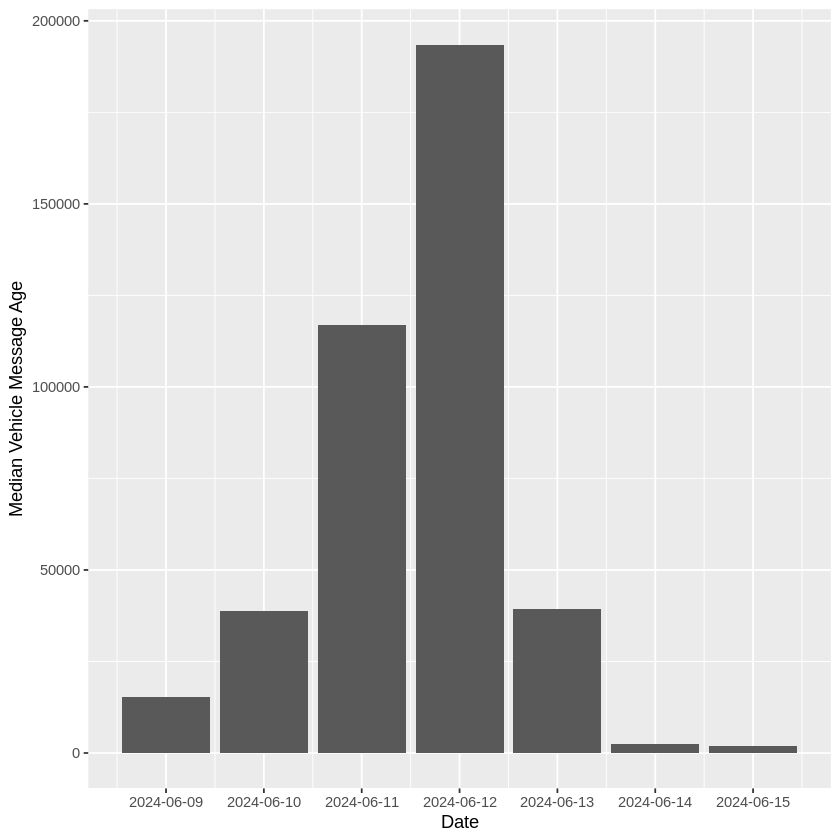

In [61]:
df21 %>% 
    ggplot(aes(Date, `Median Vehicle Message Age`)) +
    geom_bar(stat = 'identity') +
    scale_x_date(breaks = df21$Date)
           
           

In [62]:
summary(df21)

      Date            Median Vehicle Message Age
 Min.   :2024-06-09   Min.   :  1790            
 1st Qu.:2024-06-10   1st Qu.:  8918            
 Median :2024-06-12   Median : 38677            
 Mean   :2024-06-12   Mean   : 58327            
 3rd Qu.:2024-06-13   3rd Qu.: 78231            
 Max.   :2024-06-15   Max.   :193524            

In [63]:
glimpse(df21)

Rows: 7
Columns: 2
$ Date                         <date> 2024-06-09, 2024-06-10, 2024-06-11, 2024…
$ `Median Vehicle Message Age` <dbl> 15333.0, 38677.0, 117050.0, 193524.0, 394…


In [64]:
query3 = "with cte1 as(
  select distinct gtfs_dataset_key
  from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
  where customer_facing is true
),
cte2 as(
SELECT 
#dt, 
#_extract_ts,
vpm.gtfs_dataset_key,
_header_message_age, 
_vehicle_message_age,
_vehicle_message_age_vs_header,
datetime(_extract_ts, 'America/Los_Angeles') as _extract_ts_pacific, 
date(datetime(_extract_ts, 'America/Los_Angeles')) as dt_pacific,
time(datetime(_extract_ts, 'America/Los_Angeles')) as hour_pacific
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
inner join cte1 c1
on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
where 
gtfs_dataset_name not like 'Bay Area 511%'
and trip_id is not null

and (dt between '2024-06-08' and '2024-06-15')
and date(datetime(_extract_ts, 'America/Los_Angeles')) between '2024-06-09' and '2024-06-15'
),

cte21 as(
select *,
case
  when time(_extract_ts_pacific) between '07:30:00' and '08:30:00' then 'AM Peak'
  when time(_extract_ts_pacific) between '12:00:00' and '13:00:00' then 'Midday'
  when time(_extract_ts_pacific) between '16:00:00' and '17:00:00' then 'PM Peak'
  when time(_extract_ts_pacific) between '21:00:00' and '22:00:00' then 'Evening'
  else null
end as time_of_day
from cte2
),
cte3 as(
select distinct
dt_pacific, 
time_of_day,
_header_message_age, 
_vehicle_message_age,
_vehicle_message_age_vs_header
from cte21
),
cte4 as(
select *,
  PERCENTILE_CONT(_vehicle_message_age, .5) OVER(PARTITION BY dt_pacific, time_of_day) AS median_vehicle_message_age
from cte3
)

select distinct dt_pacific, time_of_day, median_vehicle_message_age
from cte4
where time_of_day is not null
order by dt_pacific, time_of_day "

In [65]:
df3 = dbGetQuery(con, query3)

In [66]:
summary(df3)

   dt_pacific         time_of_day        median_vehicle_message_age
 Min.   :2024-06-09   Length:27          Min.   : 156.0            
 1st Qu.:2024-06-10   Class :character   1st Qu.: 250.0            
 Median :2024-06-12   Mode  :character   Median : 376.0            
 Mean   :2024-06-11                      Mean   : 732.8            
 3rd Qu.:2024-06-13                      3rd Qu.: 513.2            
 Max.   :2024-06-15                      Max.   :7363.0            

In [67]:
glimpse(df3)

Rows: 27
Columns: 3
$ dt_pacific                 <date> 2024-06-09, 2024-06-09, 2024-06-09, 2024-0…
$ time_of_day                <chr> "AM Peak", "Evening", "Midday", "PM Peak", …
$ median_vehicle_message_age <dbl> 219.0, 7363.0, 248.0, 252.0, 358.0, 1649.0,…


In [68]:
factor_level = c("AM Peak", "Midday", "PM Peak", "Evening")
df3$time_of_day = factor(df3$time_of_day, levels = factor_level)
df3

dt_pacific,time_of_day,median_vehicle_message_age
<date>,<fct>,<dbl>
2024-06-09,AM Peak,219.0
2024-06-09,Evening,7363.0
2024-06-09,Midday,248.0
2024-06-09,PM Peak,252.0
2024-06-10,AM Peak,358.0
2024-06-10,Evening,1649.0
2024-06-10,Midday,652.0
2024-06-10,PM Peak,509.5
2024-06-11,AM Peak,415.0


In [69]:
df3 = df3 %>% 
    select(Date = dt_pacific, `Time of Day` = time_of_day, `Median Vehicle Message Age` = median_vehicle_message_age) %>%
    arrange(Date, `Time of Day`)

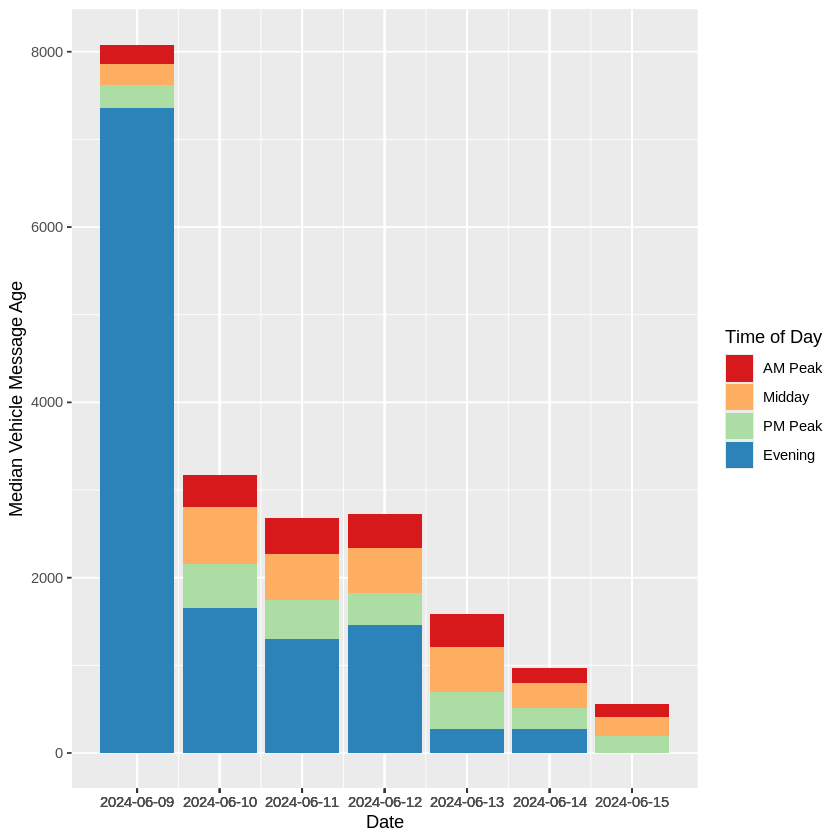

In [70]:
df3 %>% 
    ggplot(aes(Date, `Median Vehicle Message Age`)) +
    geom_bar(aes(fill = `Time of Day`), stat = 'identity') +
    scale_x_date(breaks = df3$Date) +
    labs(fill='Time of Day') +
    scale_fill_brewer(palette="Spectral")


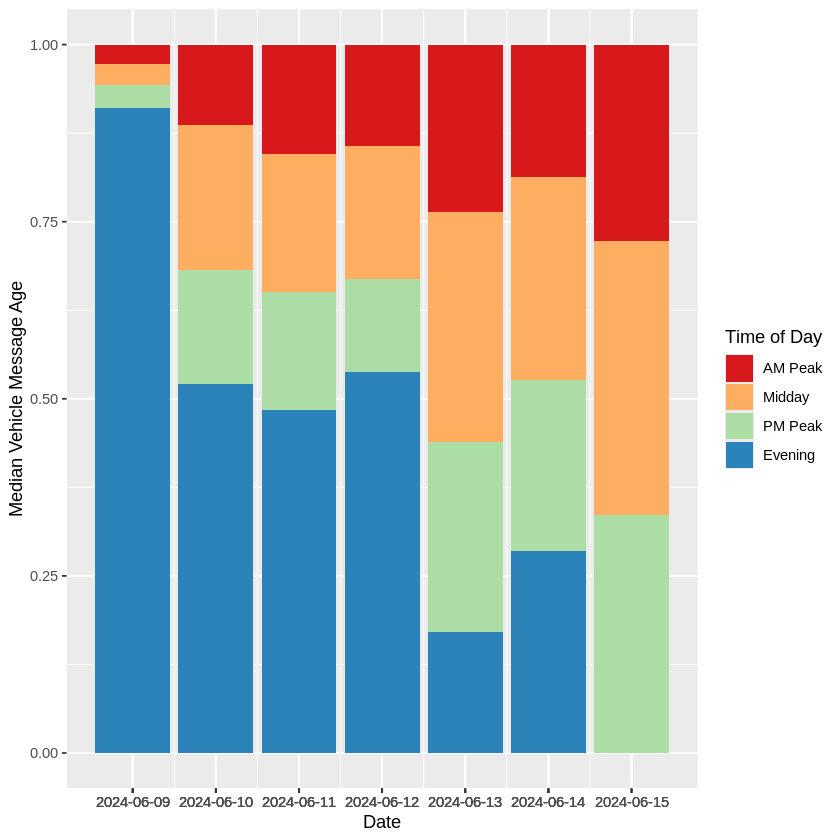

In [71]:
df3 %>% 
    ggplot(aes(Date, `Median Vehicle Message Age`)) +
    geom_bar(aes(fill = `Time of Day`), stat = 'identity', position = "fill") +
    scale_x_date(breaks = df3$Date) +
    labs(fill='Time of Day') +
    scale_fill_brewer(palette="Spectral")


In [72]:
query4 = "with cte1 as(
  select distinct gtfs_dataset_key
  from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
  where customer_facing is true
),
cte2 as(
SELECT 
vpm.gtfs_dataset_name, 
_header_message_age, 
_vehicle_message_age,
_vehicle_message_age_vs_header,
#datetime(_extract_ts, 'America/Los_Angeles') as _extract_ts_pacific, 
#date(datetime(_extract_ts, 'America/Los_Angeles')) as dt_pacific,
#time(datetime(_extract_ts, 'America/Los_Angeles')) as hour_pacific
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
inner join cte1 c1
on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
where 
gtfs_dataset_name not like 'Bay Area 511%'
and trip_id is not null
and dt between '2024-06-11' and '2024-06-12'
and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
),

cte3 as(
select distinct
gtfs_dataset_name,
_header_message_age, 
_vehicle_message_age,
_vehicle_message_age_vs_header
from cte2
),
cte4 as(
select *,
  PERCENTILE_CONT(_vehicle_message_age, .5) OVER(PARTITION BY gtfs_dataset_name) AS median_vehicle_message_age
from cte3
)

select distinct gtfs_dataset_name, median_vehicle_message_age
from cte4
where median_vehicle_message_age is not null
order by median_vehicle_message_age"
df4 = dbGetQuery(con, query4)
df4

gtfs_dataset_name,median_vehicle_message_age
<chr>,<dbl>
Emery Go-Round TripShot Vehicle Positions,1.0
Santa Maria Vehicle Positions,1.5
BruinBus Vehicle Positions,2.0
TCRTA Vehicle Positions,2.0
Anaheim Resort VehiclePositions,2.5
Humboldt Vehicle Positions,5.0
Beaumont Pass Vehicle Positions,8.0
Tahoe Transportation District GMV VehiclePositions,9.0
Culver City VehiclePositions,14.0


In [91]:
#df4 = df4 %>% select(`GTFS Feed Name` = gtfs_dataset_name, `Median Vehicle Message Age` = median_vehicle_message_age)
#df4

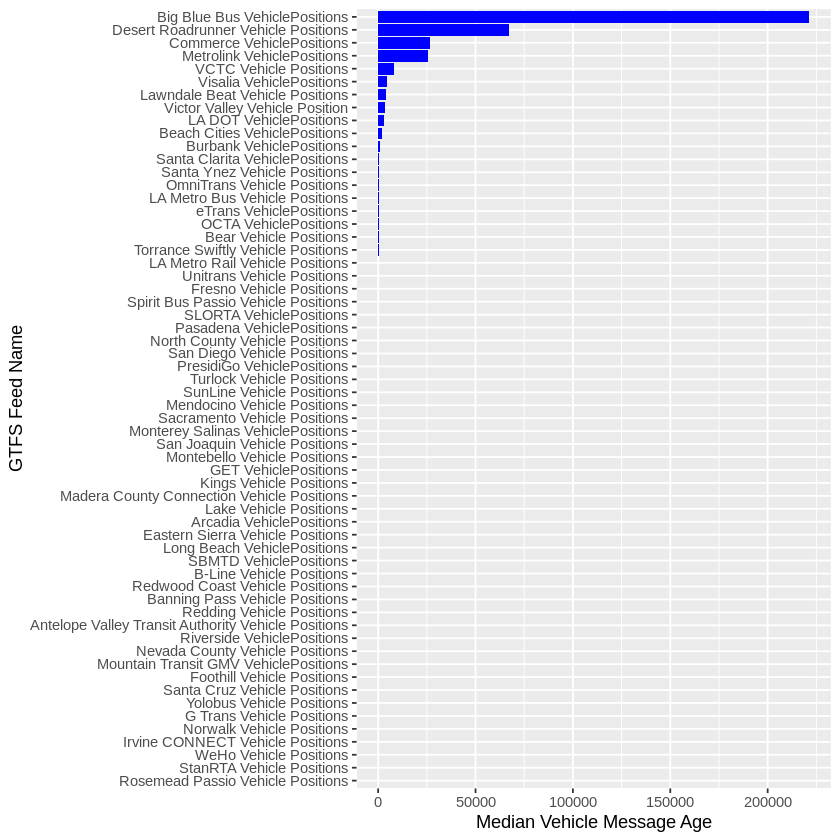

In [108]:
df4 %>% 
    filter(
        `Median Vehicle Message Age`> 20
        ) %>% 
    ggplot(aes(reorder(`GTFS Feed Name`, `Median Vehicle Message Age`), `Median Vehicle Message Age`)) +
    geom_bar(stat = 'identity', fill = "blue") +
    xlab("GTFS Feed Name") +
    # theme(axis.text.x = element_text(angle = 90)) +
    coord_flip()


In [111]:
df5 = df4
df5$`GTFS Feed Name`= df5$`GTFS Feed Name` %>% str_replace(" Vehicle Position", "")
df5$`GTFS Feed Name`= df5$`GTFS Feed Name` %>% str_replace(" VehiclePosition", "")

# df5

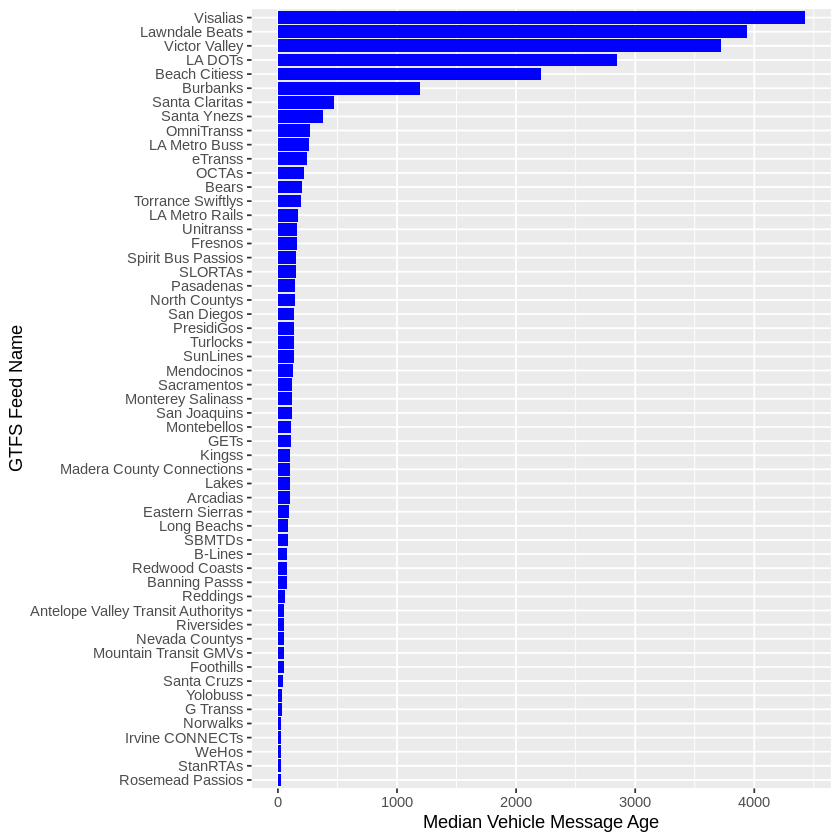

In [110]:
df5 %>% 
    filter(
        `Median Vehicle Message Age`> 20
        ,
        `Median Vehicle Message Age`< 5000
        ) %>% 
    ggplot(aes(reorder(`GTFS Feed Name`, `Median Vehicle Message Age`), `Median Vehicle Message Age`)) +
    geom_bar(stat = 'identity', fill = "blue") +
    xlab("GTFS Feed Name") +
    coord_flip()
    # theme(axis.text.x = element_text(angle = 90)) 
    # theme(axis.text.x = element_text(angle = 45, vjust=0.5)) 
    # scale_fill_brewer(palette="Spectral")

In [112]:
# query8 = "SELECT organization_name, gtfs_dataset_name
# FROM `cal-itp-data-infra.mart_transit_database.bridge_organizations_x_gtfs_datasets_produced` 
# where _is_current is true
# "
# df8 = dbGetQuery(con, query8)
# df8 

In [113]:
# df4 %>% 
#     inner_join(df8, by = c("GTFS Feed Name" = "gtfs_dataset_name")) %>% 
#     arrange(`GTFS Feed Name`)

In [114]:
# df4 %>% 
#     inner_join(df8, by = c("GTFS Feed Name" = "gtfs_dataset_name")) %>% 
#     select(organization_name, `Median Vehicle Message Age`) %>%  
#     arrange(`Median Vehicle Message Age`)

In [141]:
# query9 = "with cte1 as(
#   select distinct gtfs_dataset_key
#   from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
#   where customer_facing is true
# ),
# cte2 as(
# SELECT 
# vpm.gtfs_dataset_name, 
# _header_message_age, 
# _vehicle_message_age
# from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
# inner join cte1 c1
# on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
# where 
# gtfs_dataset_name not like 'Bay Area 511%'
# and trip_id is not null
# and dt between '2024-06-11' and '2024-06-12'
# and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
# ),
# cte21 as(
#   select
#   organization_name,
#   _header_message_age, 
#   _vehicle_message_age
#   from cte2 c2
#   inner join `cal-itp-data-infra.mart_transit_database.bridge_organizations_x_gtfs_datasets_produced` bo
#   on c2.gtfs_dataset_name = bo.gtfs_dataset_name
#   where _is_current is true
# ),
# cte3 as(
# select distinct
# organization_name,
# _header_message_age, 
# _vehicle_message_age
# from cte21
# ),
# cte4 as(
# select *,
#   PERCENTILE_CONT(_vehicle_message_age, .5) OVER(PARTITION BY organization_name) AS median_vehicle_message_age
# from cte3
# ),
# cte5 as(
# select distinct organization_name, median_vehicle_message_age
# from cte4
# where median_vehicle_message_age is not null
# order by median_vehicle_message_age 
# )

# select * from cte5"
# df9 = dbGetQuery(con, query9)
# df9 

In [142]:
# query91 = "with cte1 as(
#   select distinct gtfs_dataset_key
#   from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
#   where customer_facing is true
# ),
# cte2 as(
# SELECT 
# vpm.gtfs_dataset_name, 
# _header_message_age, 
# _vehicle_message_age
# from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
# inner join cte1 c1
# on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
# where 
# gtfs_dataset_name not like 'Bay Area 511%'
# and trip_id is not null
# and dt between '2024-06-11' and '2024-06-12'
# and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
# ),
# cte21 as(
#   select
#   organization_name,
#   _header_message_age, 
#   _vehicle_message_age
#   from cte2 c2
#   inner join `cal-itp-data-infra.mart_transit_database.bridge_organizations_x_gtfs_datasets_produced` bo
#   on c2.gtfs_dataset_name = bo.gtfs_dataset_name
# #  where _is_current is true
# ),
# cte3 as(
# select distinct
# organization_name,
# _header_message_age, 
# _vehicle_message_age
# from cte21
# ),
# cte4 as(
# select *,
#   PERCENTILE_CONT(_vehicle_message_age, .5) OVER(PARTITION BY organization_name) AS median_vehicle_message_age
# from cte3
# ),
# cte5 as(
# select distinct organization_name, median_vehicle_message_age
# from cte4
# where median_vehicle_message_age is not null
# order by median_vehicle_message_age 
# )

# select * from cte5"
# df91 = dbGetQuery(con, query91)
# df91 

In [143]:
# query92 = "with cte1 as(
#   select distinct gtfs_dataset_key
#   from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
#   where customer_facing is true
# ),
# cte2 as(
# SELECT 
# vpm.gtfs_dataset_name, 
# _header_message_age, 
# _vehicle_message_age
# from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
# inner join cte1 c1
# on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
# where 
# gtfs_dataset_name not like 'Bay Area 511%'
# and trip_id is not null
# and dt between '2024-06-11' and '2024-06-12'
# and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
# ),
# cte21 as(
#   select
#   organization_name,
#   _header_message_age, 
#   _vehicle_message_age
#   from cte2 c2
#   inner join `cal-itp-data-infra.mart_transit_database.bridge_organizations_x_gtfs_datasets_produced` bo
#   on c2.gtfs_dataset_name = bo.gtfs_dataset_name
#   where #_is_current is true
#   '2024-06-12' between date(datetime(_valid_from, 'America/Los_Angeles')) and date(datetime(_valid_to, 'America/Los_Angeles'))
#    and organization_name != 'Anaheim Transportation Network'
#    and organization_name != 'City of Santa Monica'
#    and organization_name != 'City of Commerce'
# ),
# cte3 as(
# select distinct
# organization_name,
# _header_message_age, 
# _vehicle_message_age
# from cte21
# ),
# cte4 as(
# select *,
#   PERCENTILE_CONT(_vehicle_message_age, .5) OVER(PARTITION BY organization_name) AS median_vehicle_message_age
# from cte3
# ),
# cte5 as(
# select distinct organization_name, median_vehicle_message_age
# from cte4
# where median_vehicle_message_age is not null
# order by median_vehicle_message_age 
# )

# select * from cte5"
# df92 = dbGetQuery(con, query92)
# df92 

In [144]:
# df92[df92$median_vehicle_message_age> 20, ] %>% 
#     ggplot(aes(reorder(organization_name, median_vehicle_message_age), median_vehicle_message_age)) +
#     geom_bar(stat = 'identity', fill = "blue") +
#     xlab("organization_name") +
#     coord_flip()
#     # theme(axis.text.x = element_text(angle = 90)) 
#     # theme(axis.text.x = element_text(angle = 45, vjust=0.5)) 

In [137]:
query94 = "with cte1 as(
  select distinct gtfs_dataset_key
  from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
  where customer_facing is true
),
cte2 as(
SELECT 
vpm.gtfs_dataset_name, 
_header_message_age, 
_vehicle_message_age
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
inner join cte1 c1
on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
where 
gtfs_dataset_name not like 'Bay Area 511%'
and trip_id is not null
and dt between '2024-06-11' and '2024-06-12'
and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
),

cte100 as(
SELECT gtfs_dataset_name, max(_valid_from) as max_valid_from
FROM `cal-itp-data-infra.mart_transit_database.bridge_organizations_x_gtfs_datasets_produced` 
where #_is_current is true
'2024-06-12' between date(datetime(_valid_from, 'America/Los_Angeles')) and date(datetime(_valid_to, 'America/Los_Angeles'))
and organization_name != 'Anaheim Transportation Network'
and organization_name != 'City of Santa Monica'
and organization_name != 'City of Commerce'
group by gtfs_dataset_name
),
cte101 as(
SELECT bo.gtfs_dataset_name, bo.organization_name
FROM `cal-itp-data-infra.mart_transit_database.bridge_organizations_x_gtfs_datasets_produced` bo
inner join cte100 c100
on bo.gtfs_dataset_name = c100.gtfs_dataset_name
where #_is_current is true
'2024-06-12' between date(datetime(_valid_from, 'America/Los_Angeles')) and date(datetime(_valid_to, 'America/Los_Angeles'))
and organization_name != 'Anaheim Transportation Network'
and organization_name != 'City of Santa Monica'
and organization_name != 'City of Commerce'
and _valid_from = c100.max_valid_from
),

cte21 as(
  select
  organization_name,
  c2.gtfs_dataset_name,
  _header_message_age, 
  _vehicle_message_age
  from cte2 c2
  inner join cte101 c101
  on c2.gtfs_dataset_name = c101.gtfs_dataset_name
)

select distinct organization_name, gtfs_dataset_name from cte21"
df94 = dbGetQuery(con, query94)
df94 

organization_name,gtfs_dataset_name
<chr>,<chr>
Los Angeles County Metropolitan Transportation Authority,Arcadia VehiclePositions
Sacramento Regional Transit District,Sacramento Vehicle Positions
GMV Syncromatics Inc,Elk Grove VehiclePositions
Swiftly Inc.,Madera County Connection Vehicle Positions
Mountain Area Regional Transit Authority,Mountain Transit GMV VehiclePositions
Cubic,Bear Vehicle Positions
TripShot Inc.,BruinBus Vehicle Positions
Yolo County Transportation District,Yolobus Vehicle Positions
Long Beach Transit,Long Beach VehiclePositions


In [140]:
query95 = "with cte1 as(
  select distinct gtfs_dataset_key
  from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
  where customer_facing is true
),
cte2 as(
SELECT 
vpm.gtfs_dataset_name, 
_header_message_age, 
_vehicle_message_age
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
inner join cte1 c1
on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
where 
gtfs_dataset_name not like 'Bay Area 511%'
and trip_id is not null
and dt between '2024-06-11' and '2024-06-12'
and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
),

cte100 as(
SELECT gtfs_dataset_name, max(_valid_from) as max_valid_from
FROM `cal-itp-data-infra.mart_transit_database.bridge_organizations_x_gtfs_datasets_produced` 
where #_is_current is true
'2024-06-12' between date(datetime(_valid_from, 'America/Los_Angeles')) and date(datetime(_valid_to, 'America/Los_Angeles'))
and organization_name != 'Anaheim Transportation Network'
and organization_name != 'City of Santa Monica'
and organization_name != 'City of Commerce'
group by gtfs_dataset_name
),
cte101 as(
SELECT bo.gtfs_dataset_name, bo.organization_name
FROM `cal-itp-data-infra.mart_transit_database.bridge_organizations_x_gtfs_datasets_produced` bo
inner join cte100 c100
on bo.gtfs_dataset_name = c100.gtfs_dataset_name
where #_is_current is true
'2024-06-12' between date(datetime(_valid_from, 'America/Los_Angeles')) and date(datetime(_valid_to, 'America/Los_Angeles'))
and organization_name != 'Anaheim Transportation Network'
and organization_name != 'City of Santa Monica'
and organization_name != 'City of Commerce'
and _valid_from = c100.max_valid_from
),

cte21 as(
  select
  organization_name,
  c2.gtfs_dataset_name,
  _header_message_age, 
  _vehicle_message_age
  from cte2 c2
  inner join cte101 c101
  on c2.gtfs_dataset_name = c101.gtfs_dataset_name
),

cte3 as(
select distinct
organization_name,
_header_message_age, 
_vehicle_message_age
from cte21
),
cte4 as(
select *,
  PERCENTILE_CONT(_vehicle_message_age, .5) OVER(PARTITION BY organization_name) AS median_vehicle_message_age
from cte3
),
cte5 as(
select distinct organization_name, median_vehicle_message_age
from cte4
where median_vehicle_message_age is not null
order by median_vehicle_message_age 
)

select * from cte5"
df95 = dbGetQuery(con, query95)

In [145]:
df95

organization_name,median_vehicle_message_age
<chr>,<dbl>
TripShot Inc.,2.5
City of Culver City,14.0
Stanislaus Regional Transit Authority,26.0
Yolo County Transportation District,33.0
City of Gardena,33.0
Clever Devices Ltd.,41.0
Passio Technologies,50.0
Mountain Area Regional Transit Authority,50.0
Riverside Transit Agency,53.0


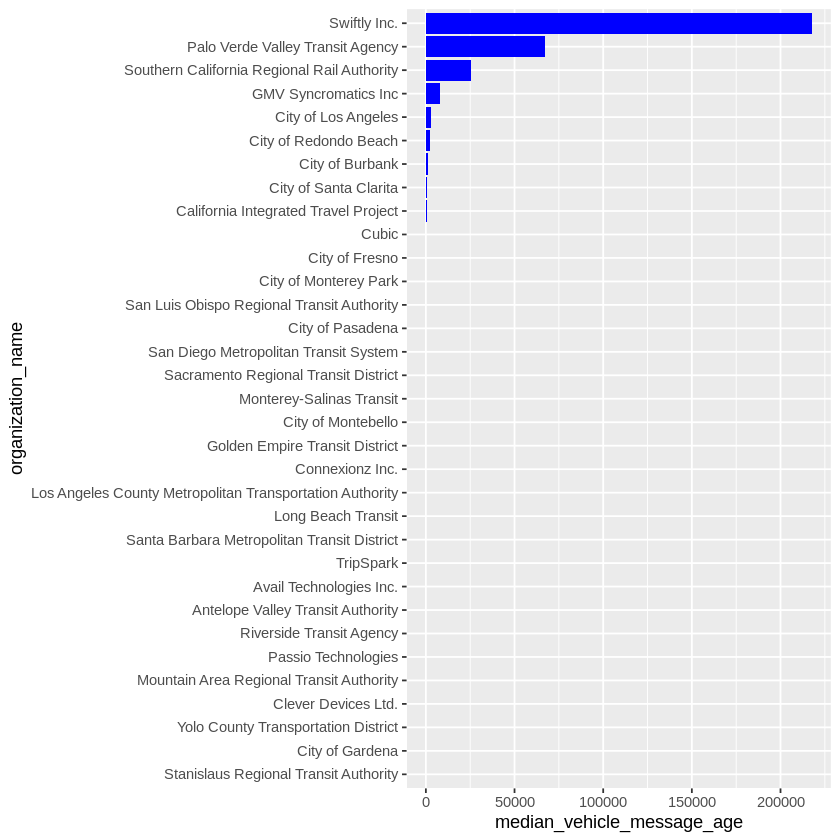

In [146]:
df95[df95$median_vehicle_message_age> 20, ] %>% 
    ggplot(aes(reorder(organization_name, median_vehicle_message_age), median_vehicle_message_age)) +
    geom_bar(stat = 'identity', fill = "blue") +
    xlab("organization_name") +
    coord_flip()
    # theme(axis.text.x = element_text(angle = 90)) 
    # theme(axis.text.x = element_text(angle = 45, vjust=0.5)) 

In [147]:
df94 %>% 
    filter(organization_name == 'California Integrated Travel Project')

organization_name,gtfs_dataset_name
<chr>,<chr>
California Integrated Travel Project,Santa Ynez Vehicle Positions


In [120]:
query10 = "with cte1 as(
  select distinct gtfs_dataset_key
  from `cal-itp-data-infra.mart_transit_database.dim_gtfs_service_data`
  where customer_facing is true
),
cte2 as(
SELECT 
schedule_feed_key, 
_header_message_age, 
_vehicle_message_age
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` vpm
inner join cte1 c1
on vpm.gtfs_dataset_key = c1.gtfs_dataset_key
where 
gtfs_dataset_name not like 'Bay Area 511%'
and trip_id is not null
and dt between '2024-06-11' and '2024-06-12'
and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
),
cte21 as(
SELECT distinct sf.key, route_type
FROM `cal-itp-data-infra.mart_gtfs.dim_trips` t
inner join `cal-itp-data-infra.mart_gtfs.dim_routes` r
on t.feed_key = r.feed_key
and t.route_id = r.route_id
inner join `cal-itp-data-infra.mart_gtfs.dim_schedule_feeds` sf
on t.base64_url = sf.base64_url
#where _is_current is true
),
cte22 as(
  select
  route_type,
  _header_message_age, 
  _vehicle_message_age
  from cte2 c2
  inner join cte21 c21
  on c2.schedule_feed_key = c21.key
),
cte3 as(
select distinct
route_type,
_header_message_age, 
_vehicle_message_age
from cte22
),
cte4 as(
select *,
  PERCENTILE_CONT(_vehicle_message_age, .5) OVER(PARTITION BY route_type) AS median_vehicle_message_age
from cte3
),
cte5 as(
select distinct route_type, median_vehicle_message_age
from cte4
where median_vehicle_message_age is not null
order by median_vehicle_message_age 
)

select * from cte5"
df10 = dbGetQuery(con, query10)
df10 

route_type,median_vehicle_message_age
<chr>,<dbl>
11,94
4,139
1,165
0,166
2,362
3,76833


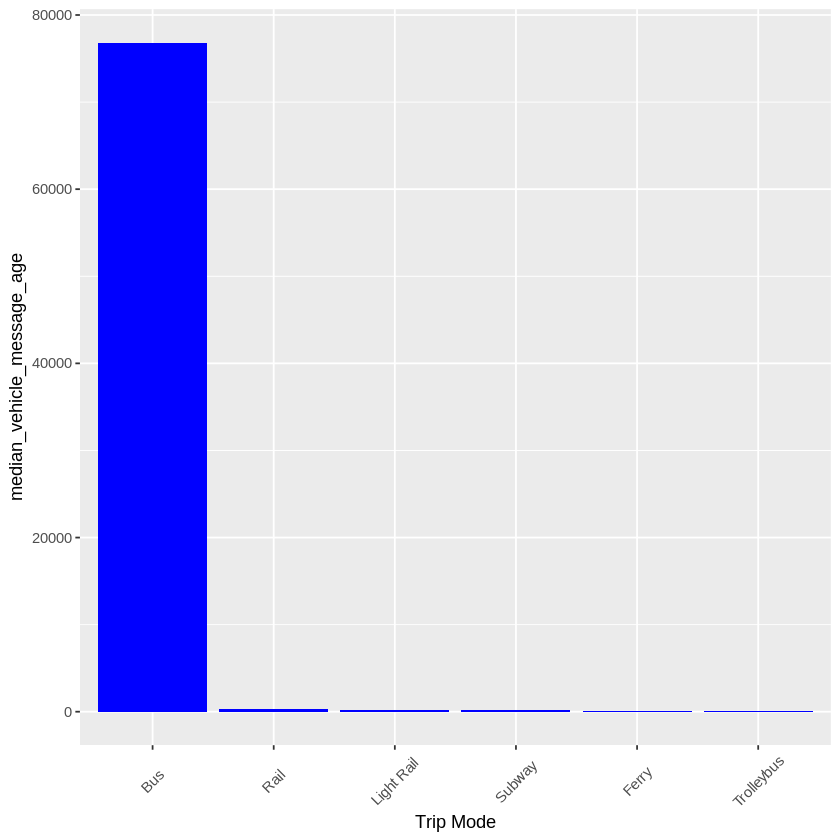

In [121]:
df10 %>% 
    mutate(`Trip Mode` = c("Trolleybus", "Ferry", "Subway", "Light Rail", "Rail", "Bus")) %>% 
    ggplot(aes(reorder(`Trip Mode`, -median_vehicle_message_age), median_vehicle_message_age)) +
    geom_bar(stat = 'identity', fill = "blue") +
    xlab("Trip Mode") +
    #theme(axis.text.x = element_text(angle = 90)) 
    theme(axis.text.x = element_text(angle = 45, vjust=0.5)) 

In [9]:
query11 = "select *, datetime(_extract_ts, 'America/Los_Angeles') as _extract_ts_pacific, 
date(datetime(_extract_ts, 'America/Los_Angeles')) as dt_pacific,
time(datetime(_extract_ts, 'America/Los_Angeles')) as hour_pacific
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` 
where (dt = '2024-06-11' or dt = '2024-06-12')
and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
and time(datetime(_extract_ts, 'America/Los_Angeles')) between '00:00:00' and '00:59:59'"
df11 = dbGetQuery(con, query11)
df11 

key,gtfs_dataset_key,dt,hour,base64_url,_extract_ts,_config_extract_ts,gtfs_dataset_name,schedule_gtfs_dataset_key,schedule_base64_url,⋯,trip_start_date,trip_schedule_relationship,position_latitude,position_longitude,position_bearing,position_odometer,position_speed,_extract_ts_pacific,dt_pacific,hour_pacific
<chr>,<chr>,<date>,<dttm>,<chr>,<dttm>,<dttm>,<chr>,<chr>,<chr>,⋯,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<date>,<time>
739d9b4371d637c0aaa2daf296f1eed0,5a3ed004c18b1388ecf8f219f5483043,2024-06-12,2024-06-12 07:00:00,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvdG9ycmFuY2UvZ3Rmcy1ydC12ZWhpY2xlLXBvc2l0aW9ucw==,2024-06-12 07:00:00,2024-06-12 02:00:42,Torrance Swiftly Vehicle Positions,7cb3592df114dab1288176f1410563a1,aHR0cHM6Ly90cmFuc2l0LnRvcnJhbmNlY2EuZ292L2hvbWUvc2hvd2RvY3VtZW50P2lkPTE2Njcz,⋯,NA,NA,33.84477,-118.3427,NA,NA,0,2024-06-12 00:00:00,2024-06-12,00:00:00
dda7c0caa13548170bf5ae8e775fb618,5a3ed004c18b1388ecf8f219f5483043,2024-06-12,2024-06-12 07:00:00,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvdG9ycmFuY2UvZ3Rmcy1ydC12ZWhpY2xlLXBvc2l0aW9ucw==,2024-06-12 07:00:00,2024-06-12 02:00:42,Torrance Swiftly Vehicle Positions,7cb3592df114dab1288176f1410563a1,aHR0cHM6Ly90cmFuc2l0LnRvcnJhbmNlY2EuZ292L2hvbWUvc2hvd2RvY3VtZW50P2lkPTE2Njcz,⋯,NA,NA,33.84464,-118.3426,NA,NA,0,2024-06-12 00:00:00,2024-06-12,00:00:00
b3e9149ae3f94f3e7cf005344ff438d8,5a3ed004c18b1388ecf8f219f5483043,2024-06-12,2024-06-12 07:00:00,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvdG9ycmFuY2UvZ3Rmcy1ydC12ZWhpY2xlLXBvc2l0aW9ucw==,2024-06-12 07:00:00,2024-06-12 02:00:42,Torrance Swiftly Vehicle Positions,7cb3592df114dab1288176f1410563a1,aHR0cHM6Ly90cmFuc2l0LnRvcnJhbmNlY2EuZ292L2hvbWUvc2hvd2RvY3VtZW50P2lkPTE2Njcz,⋯,NA,NA,33.84468,-118.3426,NA,NA,0,2024-06-12 00:00:00,2024-06-12,00:00:00
e08a293942c9890e47b5005c200d6f54,5a3ed004c18b1388ecf8f219f5483043,2024-06-12,2024-06-12 07:00:00,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvdG9ycmFuY2UvZ3Rmcy1ydC12ZWhpY2xlLXBvc2l0aW9ucw==,2024-06-12 07:00:20,2024-06-12 02:00:42,Torrance Swiftly Vehicle Positions,7cb3592df114dab1288176f1410563a1,aHR0cHM6Ly90cmFuc2l0LnRvcnJhbmNlY2EuZ292L2hvbWUvc2hvd2RvY3VtZW50P2lkPTE2Njcz,⋯,NA,NA,33.84477,-118.3427,NA,NA,0,2024-06-12 00:00:20,2024-06-12,00:00:20
c8da55b5e1dd4aeebaa9e52fb7a2d491,5a3ed004c18b1388ecf8f219f5483043,2024-06-12,2024-06-12 07:00:00,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvdG9ycmFuY2UvZ3Rmcy1ydC12ZWhpY2xlLXBvc2l0aW9ucw==,2024-06-12 07:00:20,2024-06-12 02:00:42,Torrance Swiftly Vehicle Positions,7cb3592df114dab1288176f1410563a1,aHR0cHM6Ly90cmFuc2l0LnRvcnJhbmNlY2EuZ292L2hvbWUvc2hvd2RvY3VtZW50P2lkPTE2Njcz,⋯,NA,NA,33.84464,-118.3426,NA,NA,0,2024-06-12 00:00:20,2024-06-12,00:00:20
dcbec808081e49364337cd626112e573,5a3ed004c18b1388ecf8f219f5483043,2024-06-12,2024-06-12 07:00:00,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvdG9ycmFuY2UvZ3Rmcy1ydC12ZWhpY2xlLXBvc2l0aW9ucw==,2024-06-12 07:00:20,2024-06-12 02:00:42,Torrance Swiftly Vehicle Positions,7cb3592df114dab1288176f1410563a1,aHR0cHM6Ly90cmFuc2l0LnRvcnJhbmNlY2EuZ292L2hvbWUvc2hvd2RvY3VtZW50P2lkPTE2Njcz,⋯,NA,NA,33.84468,-118.3426,NA,NA,0,2024-06-12 00:00:20,2024-06-12,00:00:20
594f950fea419b97b6ae2ed0f8e6ed02,5a3ed004c18b1388ecf8f219f5483043,2024-06-12,2024-06-12 07:00:00,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvdG9ycmFuY2UvZ3Rmcy1ydC12ZWhpY2xlLXBvc2l0aW9ucw==,2024-06-12 07:00:40,2024-06-12 02:00:42,Torrance Swiftly Vehicle Positions,7cb3592df114dab1288176f1410563a1,aHR0cHM6Ly90cmFuc2l0LnRvcnJhbmNlY2EuZ292L2hvbWUvc2hvd2RvY3VtZW50P2lkPTE2Njcz,⋯,NA,NA,33.84477,-118.3427,NA,NA,0,2024-06-12 00:00:40,2024-06-12,00:00:40
e7f1115e00a1892cc3a7856b3bcbc08a,5a3ed004c18b1388ecf8f219f5483043,2024-06-12,2024-06-12 07:00:00,aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFsLXRpbWUvdG9ycmFuY2UvZ3Rmcy1ydC12ZWhpY2xlLXBvc2l0aW9ucw==,2024-06-12 07:00:40,2024-06-12 02:00:42,Torrance Swiftly Vehicle Positions,7cb3592df114dab1288176f1410563a1,aHR0cHM6Ly90cmFuc2l0LnRvcnJhbmNlY2EuZ292L2hvbWUvc2hvd2RvY3VtZW50P2lkPTE2Njcz,⋯,NA,NA,33.84464,-118.3426,NA,NA,0

In [10]:
summary(df11)

     key            gtfs_dataset_key         dt            
 Length:572709      Length:572709      Min.   :2024-06-12  
 Class :character   Class :character   1st Qu.:2024-06-12  
 Mode  :character   Mode  :character   Median :2024-06-12  
                                       Mean   :2024-06-12  
                                       3rd Qu.:2024-06-12  
                                       Max.   :2024-06-12  
                                                           
      hour                      base64_url         _extract_ts                 
 Min.   :2024-06-12 07:00:00   Length:572709      Min.   :2024-06-12 07:00:00  
 1st Qu.:2024-06-12 07:00:00   Class :character   1st Qu.:2024-06-12 07:13:40  
 Median :2024-06-12 07:00:00   Mode  :character   Median :2024-06-12 07:28:00  
 Mean   :2024-06-12 07:00:00                      Mean   :2024-06-12 07:28:38  
 3rd Qu.:2024-06-12 07:00:00                      3rd Qu.:2024-06-12 07:43:20  
 Max.   :2024-06-12 07:00:00            

In [14]:
dim(df11)

[1] 572709     47

In [15]:
query12 = "select *, datetime(_extract_ts, 'America/Los_Angeles') as _extract_ts_pacific, 
date(datetime(_extract_ts, 'America/Los_Angeles')) as dt_pacific,
time(datetime(_extract_ts, 'America/Los_Angeles')) as hour_pacific
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` 
where (dt = '2024-06-11' or dt = '2024-06-12')
and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
and time(datetime(_extract_ts, 'America/Los_Angeles')) between '01:00:00' and '01:59:59'"
df12 = dbGetQuery(con, query12)
df12 

key,gtfs_dataset_key,dt,hour,base64_url,_extract_ts,_config_extract_ts,gtfs_dataset_name,schedule_gtfs_dataset_key,schedule_base64_url,⋯,trip_start_date,trip_schedule_relationship,position_latitude,position_longitude,position_bearing,position_odometer,position_speed,_extract_ts_pacific,dt_pacific,hour_pacific
<chr>,<chr>,<date>,<dttm>,<chr>,<dttm>,<dttm>,<chr>,<chr>,<chr>,⋯,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<date>,<time>
71d7efe1d82860f483e37e4e4e29bcb9,4a484f12beac0f078b837c12e51933d2,2024-06-12,2024-06-12 08:00:00,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcy1ydC92ZWhpY2xlcG9zaXRpb25z,2024-06-12 08:00:00,2024-06-12 02:00:42,Commerce VehiclePositions,eaabdf2b0bb899b7953ea81047fdd00d,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcw==,⋯,2024-06-11,NA,33.99242,-118.1611,188.2557,NA,0,2024-06-12 01:00:00,2024-06-12,01:00:00
e43d2602df88cf1a4f4cd4d3d07c79e2,4a484f12beac0f078b837c12e51933d2,2024-06-12,2024-06-12 08:00:00,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcy1ydC92ZWhpY2xlcG9zaXRpb25z,2024-06-12 08:00:20,2024-06-12 02:00:42,Commerce VehiclePositions,eaabdf2b0bb899b7953ea81047fdd00d,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcw==,⋯,2024-06-11,NA,33.99242,-118.1611,188.2557,NA,0,2024-06-12 01:00:20,2024-06-12,01:00:20
a3dea44984bf18f54c62db81e385a119,4a484f12beac0f078b837c12e51933d2,2024-06-12,2024-06-12 08:00:00,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcy1ydC92ZWhpY2xlcG9zaXRpb25z,2024-06-12 08:00:40,2024-06-12 02:00:42,Commerce VehiclePositions,eaabdf2b0bb899b7953ea81047fdd00d,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcw==,⋯,2024-06-11,NA,33.99242,-118.1611,188.2557,NA,0,2024-06-12 01:00:40,2024-06-12,01:00:40
ff002e9528f0740821e8313a005ab913,4a484f12beac0f078b837c12e51933d2,2024-06-12,2024-06-12 08:00:00,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcy1ydC92ZWhpY2xlcG9zaXRpb25z,2024-06-12 08:01:00,2024-06-12 02:00:42,Commerce VehiclePositions,eaabdf2b0bb899b7953ea81047fdd00d,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcw==,⋯,2024-06-11,NA,33.99242,-118.1611,188.2557,NA,0,2024-06-12 01:01:00,2024-06-12,01:01:00
ac045b2dc04fe1d0e4d5357c23922f57,4a484f12beac0f078b837c12e51933d2,2024-06-12,2024-06-12 08:00:00,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcy1ydC92ZWhpY2xlcG9zaXRpb25z,2024-06-12 08:01:20,2024-06-12 02:00:42,Commerce VehiclePositions,eaabdf2b0bb899b7953ea81047fdd00d,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcw==,⋯,2024-06-11,NA,33.99242,-118.1611,188.2557,NA,0,2024-06-12 01:01:20,2024-06-12,01:01:20
1892e5f7467bd3c12b66caee9e894974,4a484f12beac0f078b837c12e51933d2,2024-06-12,2024-06-12 08:00:00,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcy1ydC92ZWhpY2xlcG9zaXRpb25z,2024-06-12 08:01:40,2024-06-12 02:00:42,Commerce VehiclePositions,eaabdf2b0bb899b7953ea81047fdd00d,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcw==,⋯,2024-06-11,NA,33.99242,-118.1611,188.2557,NA,0,2024-06-12 01:01:40,2024-06-12,01:01:40
273e476b89bbe7eac87581ac0b6cc313,4a484f12beac0f078b837c12e51933d2,2024-06-12,2024-06-12 08:00:00,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcy1ydC92ZWhpY2xlcG9zaXRpb25z,2024-06-12 08:02:00,2024-06-12 02:00:42,Commerce VehiclePositions,eaabdf2b0bb899b7953ea81047fdd00d,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcw==,⋯,2024-06-11,NA,33.99242,-118.1611,188.2557,NA,0,2024-06-12 01:02:00,2024-06-12,01:02:00
d571994ac1d40e18ecaa52981acde6f8,4a484f12beac0f078b837c12e51933d2,2024-06-12,2024-06-12 08:00:00,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcy1ydC92ZWhpY2xlcG9zaXRpb25z,2024-06-12 08:02:20,2024-06-12 02:00:42,Commerce VehiclePositions,eaabdf2b0bb899b7953ea81047fdd00d,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcw==,⋯,2024-06-11,NA,33.99242,-118.1611,188.2557,NA,0,2024-06-12 01:02:20,2024-06-12,01:02:20
34075c4046c0740c52e452eb1827e218,4a484f12beac0f078b837c12e51933d2,2024-06-12,2024-06-12 08:00:00,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcy1ydC92ZWhpY2xlcG9zaXRpb25z,2024-06-12 08:02:40,2024-06-12 02:00:42,Commerce VehiclePositions,eaabdf2b0bb899b7953ea81047fdd00d,aHR0cHM6Ly9jaXR5Y29tbWJ1cy5jb20vZ3Rmcw==,⋯,2024-06-11,NA,33.99242,-118.1611,188.2557,NA,0,2024-06-12 01:02:40,2024-06-12,01:02:40


In [16]:
dim(df12)

[1] 448037     47

In [17]:
df1112 = bind_rows(df11, df12)

In [18]:
dim(df1112)

[1] 1020746      47

In [21]:
saveRDS(df1112, "data/fct_vehicle_positions_messages.rds")

In [22]:
x = readRDS("data/fct_vehicle_positions_messages.rds")

In [23]:
dim(x)

[1] 1020746      47

In [24]:
glimpse(x)

Rows: 1,020,746
Columns: 47
$ key                              <chr> "739d9b4371d637c0aaa2daf296f1eed0", "…
$ gtfs_dataset_key                 <chr> "5a3ed004c18b1388ecf8f219f5483043", "…
$ dt                               <date> 2024-06-12, 2024-06-12, 2024-06-12, …
$ hour                             <dttm> 2024-06-12 07:00:00, 2024-06-12 07:0…
$ base64_url                       <chr> "aHR0cHM6Ly9hcGkuZ29zd2lmdC5seS9yZWFs…
$ `_extract_ts`                    <dttm> 2024-06-12 07:00:00, 2024-06-12 07:0…
$ `_config_extract_ts`             <dttm> 2024-06-12 02:00:42, 2024-06-12 02:0…
$ gtfs_dataset_name                <chr> "Torrance Swiftly Vehicle Positions",…
$ schedule_gtfs_dataset_key        <chr> "7cb3592df114dab1288176f1410563a1", "…
$ schedule_base64_url              <chr> "aHR0cHM6Ly90cmFuc2l0LnRvcnJhbmNlY2Eu…
$ schedule_name                    <chr> "Torrance Schedule", "Torrance Schedu…
$ schedule_feed_key                <chr> "3eb175018d2ad71b8b6d1c01eb115121", "…
$ schedule_f

In [4]:
x = readRDS("data/fct_vehicle_positions_messages5.rds")

In [5]:
querya = "select *, datetime(_extract_ts, 'America/Los_Angeles') as _extract_ts_pacific, 
date(datetime(_extract_ts, 'America/Los_Angeles')) as dt_pacific,
time(datetime(_extract_ts, 'America/Los_Angeles')) as hour_pacific
from `cal-itp-data-infra.mart_gtfs.fct_vehicle_positions_messages` 
where (dt = '2024-06-11' or dt = '2024-06-12')
and date(datetime(_extract_ts, 'America/Los_Angeles')) = '2024-06-12'
and time(datetime(_extract_ts, 'America/Los_Angeles')) between '"
queryb = ":00:00' and '"
queryc = ":59:59'"

In [6]:
dfr = x

In [7]:
t = c("06", "07", "08", "09", as.character(10:23))

In [9]:
for(i in t){
    print(i)
    query = paste0(querya, i, queryb, i, queryc)
    df = dbGetQuery(con, query)
    dfr = bind_rows(dfr, df)
    print(dim(dfr))
    }

[1] "06"


ERROR: [1m[33mError[39m:[22m
[1m[22m[33m![39m Request had invalid authentication credentials. Expected OAuth 2
  access token, login cookie or other valid authentication credential. See
  https://developers.google.com/identity/sign-in/web/devconsole-project.
  [authError]


In [ ]:
 saveRDS(dfr, "data/fct_vehicle_positions_messages6.rds")

In [ ]:
dfr$hour_pacific

In [1]:
querya

ERROR: Error in eval(expr, envir, enclos): object 'querya' not found


In [2]:
dim(dfr)

ERROR: Error in eval(expr, envir, enclos): object 'dfr' not found


In [5]:
x = readRDS("data/fct_vehicle_positions_messages5.rds")

In [1]:
dim(x)

ERROR: Error in eval(expr, envir, enclos): object 'x' not found


In [2]:
dfr

ERROR: Error in eval(expr, envir, enclos): object 'dfr' not found


In [123]:
df10

route_type,median_vehicle_message_age
<chr>,<dbl>
11,94
4,139
1,165
0,166
2,362
3,76833
